In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

In [2]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 10010 files belonging to 2 classes.


In [4]:
folder_names = dataset.class_names
print(folder_names)

['Fake', 'Real']


In [5]:
print(type(dataset.take(0)))

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [6]:
for image in dataset.take(1):
    print(image)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[105.,  80.,  75.],
         [ 82.,  59.,  53.],
         [ 49.,  32.,  25.],
         ...,
         [128., 127., 123.],
         [126., 125., 121.],
         [123., 122., 118.]],

        [[ 95.,  70.,  65.],
         [ 83.,  63.,  56.],
         [ 45.,  28.,  21.],
         ...,
         [128., 127., 123.],
         [127., 126., 122.],
         [125., 124., 120.]],

        [[106.,  82.,  78.],
         [ 65.,  46.,  40.],
         [ 56.,  41.,  36.],
         ...,
         [128., 127., 123.],
         [128., 127., 123.],
         [127., 126., 122.]],

        ...,

        [[ 46.,  58., 100.],
         [ 43.,  56.,  98.],
         [ 45.,  60.,  99.],
         ...,
         [ 65.,  73.,  94.],
         [111., 119., 130.],
         [162., 169., 175.]],

        [[ 63.,  86., 127.],
         [ 50.,  76., 113.],
         [ 52.,  81., 115.],
         ...,
         [ 98., 104., 126.],
         [ 97., 102., 122.],
       

In [7]:
for image in dataset.take(1):
    print(image[0].shape)

(32, 256, 256, 3)


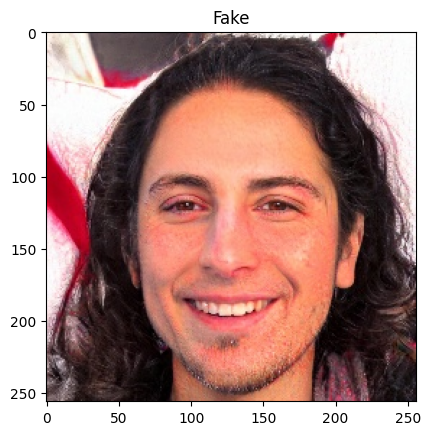

In [8]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(folder_names[label_batch[0]])

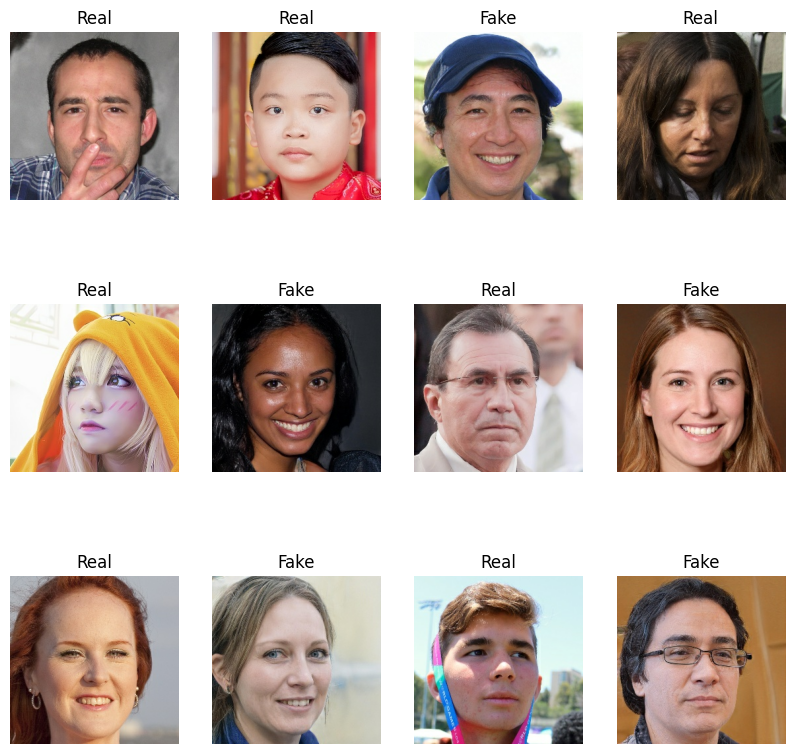

In [9]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(folder_names[label_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

313

In [11]:
train_dataset = dataset.take(250)
len(train_dataset)

250

In [12]:
test_dataset = dataset.skip(250)
len(test_dataset)

63

In [13]:
def partition_dataset(dataset, train_size = 0.8, test_size = 0.1, valid_size = 0.1, shuffle = True, shuffle_size = 10000):
    
    assert (train_size + test_size + valid_size) == 1

    size_dataset = len(dataset)

    if shuffle == True:
        dataset.shuffle(shuffle_size, seed = 5)

    train_data_size = int(size_dataset * train_size)
    valid_data_size = int(size_dataset * valid_size)
    test_data_size = int(size_dataset * test_size)

    train_dataset = dataset.take(train_data_size)
    valid_dataset = dataset.skip(train_data_size).take(valid_data_size)
    test_dataset = dataset.skip(train_data_size).skip(valid_data_size).take(test_data_size)

    return train_dataset, valid_dataset, test_dataset


In [14]:
train_dataset, valid_dataset, test_dataset = partition_dataset(dataset)

In [15]:
len(train_dataset)

250

In [16]:
len(test_dataset), len(valid_dataset)

(31, 31)

In [17]:

train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_dataset = valid_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
preprocessing = tf.keras.Sequential([
  layers.Resizing(Image_size, Image_size),
  layers.Rescaling(1./255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
input_shape = (Image_size, Image_size, Channels)

In [21]:
model = models.Sequential()

pre_trained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling='avg',
    classes=2,  # Assuming you want to classify between 2 classes
    classifier_activation="softmax",
)

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

model.add(pre_trained_model)
model.add(layers.Flatten())

# Add a dummy input to force the layers to be built
dummy_input = np.ones((1,) + input_shape)
_ = model.predict(dummy_input)

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


In [22]:
model.build()

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (1, 1280)                   │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 1280)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 512)                    │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_dataset,
    batch_size=Batch_size,
    validation_data=valid_dataset,
    verbose=1,
    epochs=5,
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 183s 703ms/step - accuracy: 0.7058 - loss: 0.5614 - val_accuracy: 0.7954 - val_loss: 0.4355
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 716ms/step - accuracy: 0.8067 - loss: 0.4145 - val_accuracy: 0.8488 - val_loss: 0.3508
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 727ms/step - accuracy: 0.8497 - loss: 0.3513 - val_accuracy: 0.8438 - val_loss: 0.3572
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 717ms/step - accuracy: 0.8739 - loss: 0.2966 - val_accuracy: 0.8065 - val_loss: 0.4262
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 716ms/step - accuracy: 0.8876 - loss: 0.2633 - val_accuracy: 0.8619 - val_loss: 0.3099


In [26]:
scores = model.evaluate(test_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 576ms/step - accuracy: 0.8685 - loss: 0.3115


In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 250}

In [29]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

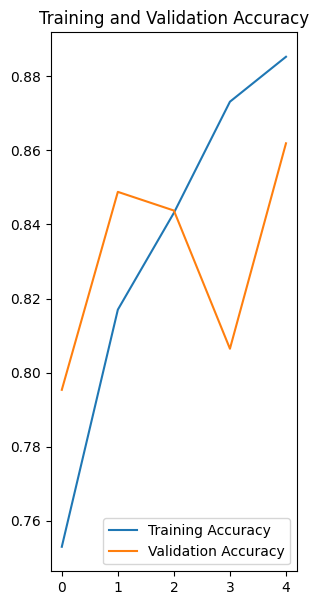

In [30]:
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 2)
plt.plot(range(5), accuracy, label = 'Training Accuracy')
plt.plot(range(5), validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

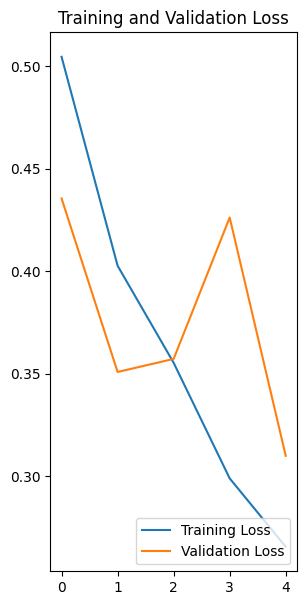

In [31]:
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label = 'Training Loss')
plt.plot(range(5), validation_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")

First Image to predict
First Image's Actual label:  Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The model prediction is: Real


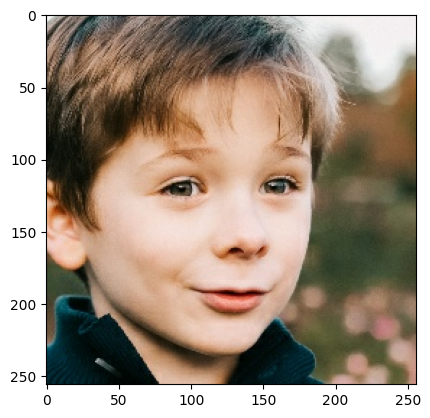

In [32]:
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("First Image to predict")
    plt.imshow(first_image)
    print("First Image's Actual label: ", folder_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    result = batch_prediction[0]
    if(result >= 0.5):
        print("The model prediction is: Real")
    else:
        print("The model prediction is: Fake")

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_probability = predictions[0][0] 

    if predicted_probability >= 0.5:
        predicted_class = 1
    else:
        predicted_class = 0
        
    confidence = round(100 * predicted_probability, 2)
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


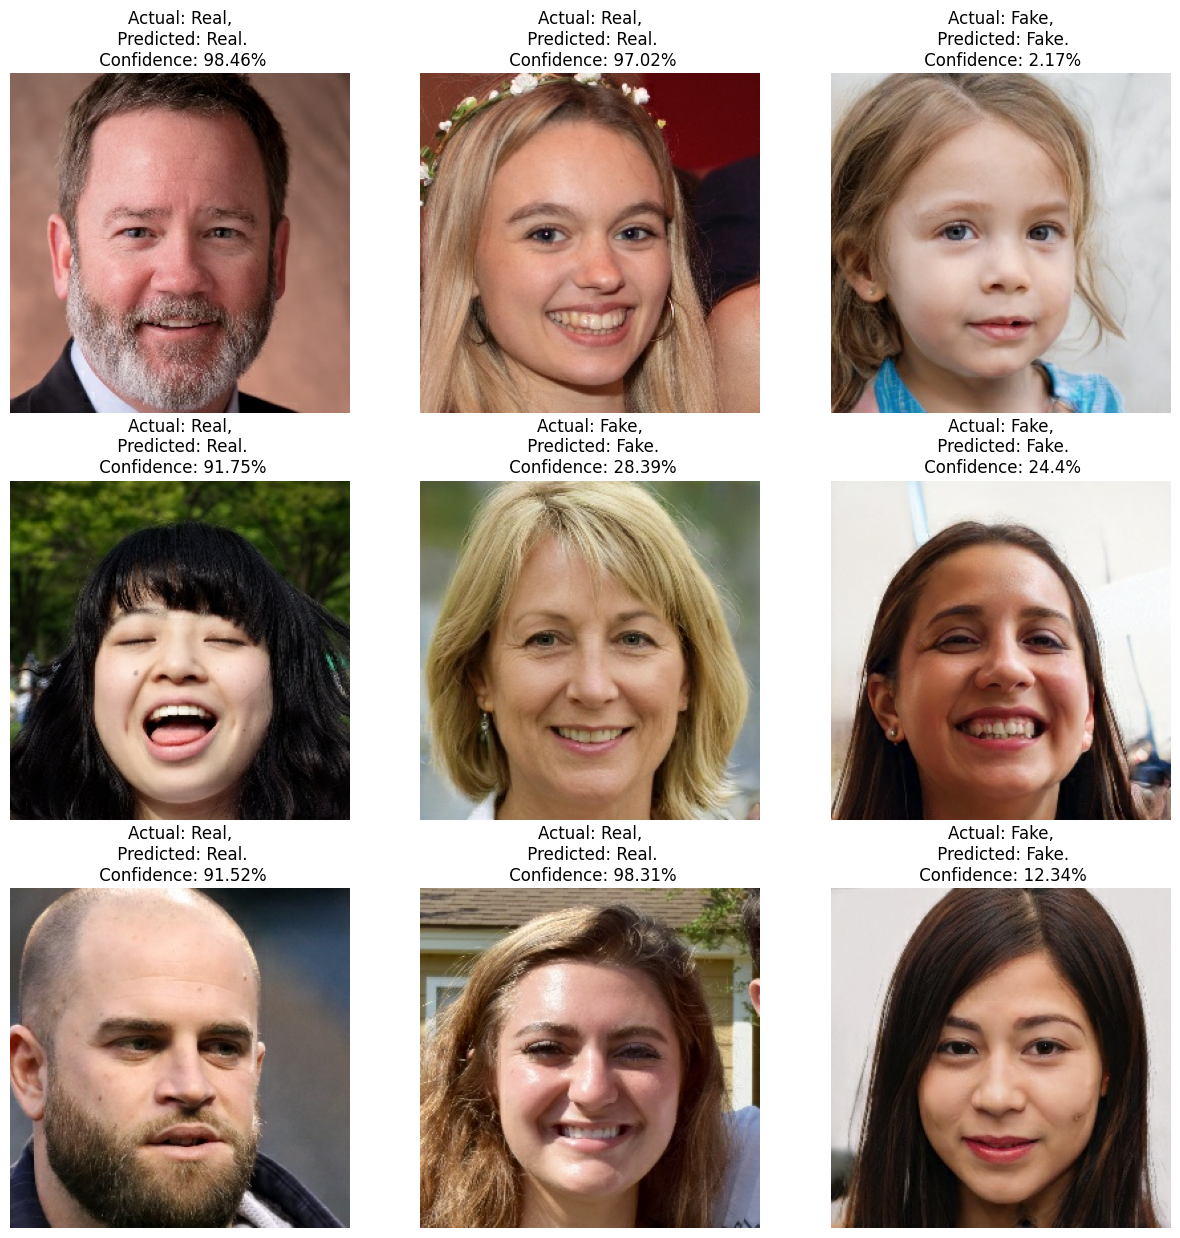

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        predicted_class = folder_names[predicted_class]
        actual_class = folder_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")